# metrics

metrics are used to evaluate how good a model is

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

df = pd.read_csv("data/creditcard.csv")[:80_000]
df.head(3), df.columns

(   Time        V1        V2        V3        V4        V5        V6        V7  \
 0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
 1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
 2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
 
          V8        V9  ...       V21       V22       V23       V24       V25  \
 0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
 1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
 2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
 
         V26       V27       V28  Amount  Class  
 0 -0.189115  0.133558 -0.021053  149.62      0  
 1  0.125895 -0.008983  0.014724    2.69      0  
 2 -0.139097 -0.055353 -0.059752  378.66      0  
 
 [3 rows x 31 columns],
 Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
        'V11', 'V12', 'V13', 'V14', 'V15'

In [2]:
X = df.drop(columns=['Time', 'Amount', 'Class'])
y = df['Class'].values

f"Shapes of X={X.shape} y={y.shape}, #Fraud Cases={y.sum()}" 
#notice: way more cases without fraud, then with (from 80k total cases only 196 are fraud)

'Shapes of X=(80000, 28) y=(80000,), #Fraud Cases=196'

In [3]:
from sklearn.linear_model import LogisticRegression

mod = LogisticRegression(class_weight={0: 1, 1:2}, max_iter=1000)
# class_weight: we have 2 different classes, class 0 = non fraud, class 1 = fraud
# we give the class 0 a weight of 0, class 1 a weight of 1
# --> by adding class_weight, we predicted 171 instead of 151 fraud cases
mod.fit(X,y).predict(X).sum()

171

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, make_scorer

def min_recall_precision(y_true, y_pred):
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    return min(recall, precision)
    

grid = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000),
    param_grid={'class_weight':[{0:1, 1:v} for v in np.linspace(1, 20, 30)]},
    scoring={'precision': make_scorer(precision_score), 
             'recall': make_scorer(recall_score),
             'min_both': make_scorer(min_recall_precision)},
    refit='min_both',
    cv = 10,
    n_jobs=-1
)
# scoring = adding scores of precision and recall to find out the best model for specific use case
# refit = what paramater do we want the model to fit
# cv = cross-validation, means the data is divided into 4 equal parts and the model will be trained and evaluated 4 times,
# with each part used once as a validation set and the 3 remaining parts used for training
# n_jobs = -1 means that all available CPU cores will be used
grid.fit(X, y)

/Users/lukasbossert/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lukasbossert/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lukasbossert/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 1.0},
                                          {0: 1, 1: 1.6551724137931034},
                                          {0: 1, 1: 2.310344827586207},
                                          {0: 1, 1: 2.9655172413793105},
                                          {0: 1, 1: 3.6206896551724137},
                                          {0: 1, 1: 4.275862068965517},
                                          {0: 1, 1: 4.931034482758621},
                                          {0: 1, 1: 5.586206896551724},
                                          {0: 1, 1: 6.241379310344827},
                                          {0: 1, 1: 6.896551724137931},...
                                          {0: 1, 1: 15.413793103448276},
                                          {0: 1, 1: 16.06896551724138},
                                          {0: 1, 1: 16.724137931034

In [5]:
precision_score(y, grid.predict(X)), recall_score(y, grid.predict(X))
# precision: given that I predict fraud how accurate am I?
# recall: did I get all the fraud cases

(0.8115942028985508, 0.8571428571428571)

In [6]:
pd.DataFrame(grid.cv_results_)
# 30 rows, for 30 different class weights (np.linspace(1, 20, 30))  (weights between 1 to 20, with 30 steps in between)
# 10 different split_test_scores (refering to cv = 10)

# in this case, the split_test_score represents the accuracy, which is really high because most of the time it gets detected as non 
# fraud --> might not be the metric we are interested in though

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,params,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,...,split3_test_min_both,split4_test_min_both,split5_test_min_both,split6_test_min_both,split7_test_min_both,split8_test_min_both,split9_test_min_both,mean_test_min_both,std_test_min_both,rank_test_min_both
0,1.106141,0.092901,0.015447,0.004760,"{0: 1, 1: 1.0}","{'class_weight': {0: 1, 1: 1.0}}",1.000000,0.463415,0.583333,1.000000,...,0.473684,0.35,0.850000,0.90,0.450000,0.00,0.40,0.483885,0.243144,30
1,0.943619,0.148852,0.019363,0.006595,"{0: 1, 1: 1.6551724137931034}","{'class_weight': {0: 1, 1: 1.6551724137931034}}",1.000000,0.463415,0.583333,1.000000,...,0.789474,0.35,0.850000,0.95,0.500000,0.25,0.50,0.565727,0.215664,29
2,0.966477,0.133622,0.015431,0.006946,"{0: 1, 1: 2.310344827586207}","{'class_weight': {0: 1, 1: 2.310344827586207}}",1.000000,0.463415,0.583333,1.000000,...,0.842105,0.40,0.850000,0.95,0.500000,0.25,0.55,0.580991,0.215860,28
3,0.942435,0.083244,0.017143,0.009839,"{0: 1, 1: 2.9655172413793105}","{'class_weight': {0: 1, 1: 2.9655172413793105}}",1.000000,0.452381,0.583333,1.000000,...,0.842105,0.40,0.850000,0.95,0.500000,0.25,0.65,0.610940,0.209877,27
4,0.816573,0.142828,0.019886,0.008101,"{0: 1, 1: 3.6206896551724137}","{'class_weight': {0: 1, 1: 3.6206896551724137}}",1.000000,0.452381,0.583333,1.000000,...,0.894737,0.45,0.850000,0.95,0.500000,0.30,0.65,0.641992,0.209095,26
5,0.846393,0.127304,0.014865,0.005384,"{0: 1, 1: 4.275862068965517}","{'class_weight': {0: 1, 1: 4.275862068965517}}",1.000000,0.452381,0.583333,1.000000,...,0.894737,0.45,0.850000,0.95,0.500000,0.35,0.70,0.662519,0.211358,25
6,0.873534,0.090794,0.013164,0.005020,"{0: 1, 1: 4.931034482758621}","{'class_weight': {0: 1, 1: 4.931034482758621}}",1.000000,0.452381,0.583333,1.000000,...,0.894737,0.45,0.850000,0.95,0.550000,0.35,0.80,0.677519,0.211711,24
7,0.830829,0.121610,0.014780,0.005417,"{0: 1, 1: 5.586206896551724}","{'class_weight': {0: 1, 1: 5.586206896551724}}",1.000000,0.452381,0.583333,1.000000,...,0.947368,0.45,0.850000,1.00,0.600000,0.35,0.80,0.692782,0.221589,23
8,0.876175,0.084952,0.012189,0.003106,"{0: 1, 1: 6.241379310344827}","{'class_weight': {0: 1, 1: 6.241379310344827}}",0.944444,0.452381,0.583333,0.947368,...,0.947368,0.50,0.850000,1.00,0.700000,0.40,0.80,0.712782,0.206133,22
9,0.905065,0.112124,0.020941,0.012250,"{0: 1, 1: 6.896551724137931}","{'class_weight': {0: 1, 1: 6.896551724137931}}",0.944444,0.452381,0.583333,0.947368,...,0.947368,0.50,0.850000,1.00,0.700000,0.50,0.80,0.722782,0.192704,20


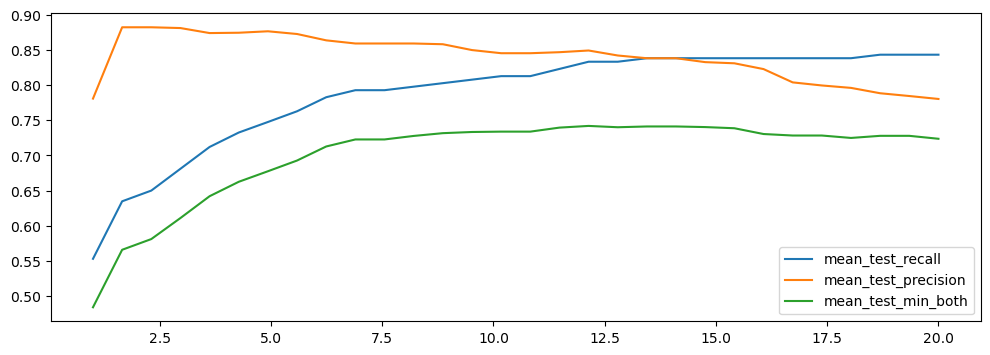

In [7]:
plt.figure(figsize=(12, 4))
df_results = pd.DataFrame(grid.cv_results_)
for score in ['mean_test_recall', 'mean_test_precision', 'mean_test_min_both']:
    plt.plot([_[1] for _ in df_results['param_class_weight']],
            df_results[score],
            label=score)
plt.legend();